## Finetune UNet baseline comparison model

#### Install required libraries

In [1]:
pip install opencv-python

In [2]:
pip install matplotlib

In [3]:
pip install tensorflow

In [4]:
pip install scikit-learn

In [5]:
pip install pydot

### Mount GDrive

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Load and Preprocess Images

In [8]:
# This code prepares image and mask data for the segmentation task by loading images and masks, resizing them, and
# organizing them into arrays for further processing.

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
from PIL import Image, ImageFilter

# Paths to image and mask folders
images_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/Train_clahe/images'
masks_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/Train_clahe/masks'

# Get list of filenames for images and masks
image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]
mask_files = [f for f in os.listdir(masks_folder) if f.endswith('.png')]

# Match image and mask filenames based on shared base names
paired_files = [(os.path.splitext(f)[0], os.path.splitext(f)[0]) for f in image_files if os.path.splitext(f)[0] + '.png' in mask_files]

image_data = []
mask_data = []

# Loop through paired files
for paired_file in paired_files:
    img_filename, mask_filename = paired_file

    img_path = os.path.join(images_folder, img_filename + '.png')
    mask_path = os.path.join(masks_folder, mask_filename + '.png')

    # Load image and mask using OpenCV, resize them, and append to respective lists
    image = cv2.imread(img_path, 0)  # Read image in grayscale
    #image = cv2.resize(image, dsize=(768, 512), interpolation=cv2.INTER_AREA)
    image_data.append(np.array(image))  # Append resized image to image_data list

    mask = cv2.imread(mask_path, 0)  # Read mask in grayscale
    #mask = cv2.resize(mask, dsize=(768, 512), interpolation=cv2.INTER_AREA)  # Resize mask
    mask_data.append(np.array(mask))  # Append resized mask to mask_data list

# Convert image_data and mask_data lists to numpy arrays, normalize values to range [0, 1]
image_data = np.expand_dims(np.array(image_data), 3) / 255  # Convert to numpy array and normalize pixel values
mask_data = np.expand_dims(np.array(mask_data), 3) / 255  # Convert to numpy array and normalize pixel values


Sanity Check -- Let's look at first image and its mask image:

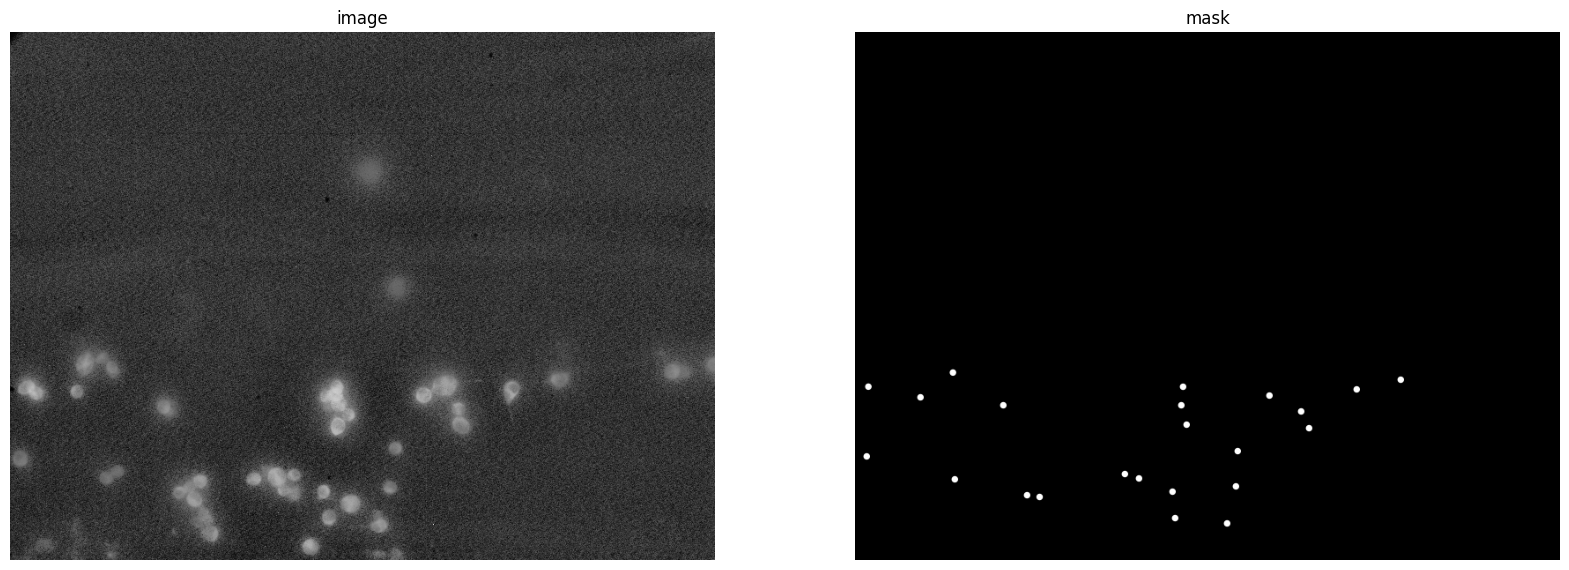

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(image_data[0], cmap='gray')
ax[0].set_title('image')
ax[0].axis('off')
ax[1].imshow(mask_data[0], cmap='gray')
ax[1].set_title('mask')
ax[1].axis('off')
fig.show()

## Let's define our U-Net Architecture

In [10]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

# Define U-Net model

# Define input shape based on image_data's dimensions
s = Input((image_data.shape[1], image_data.shape[2], image_data.shape[3]))

# Contraction path
# First set of convolutional layers and pooling
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

# Second set of convolutional layers and pooling
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

# Third set of convolutional layers
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

# Expansive path
# First upsampling and concatenation with skip connection
u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, c2])
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

# Second upsampling and concatenation with skip connection
u5 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = concatenate([u5, c1], axis=3)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

# Create the model
model = Model(inputs=[s], outputs=[outputs])

# Compile the model
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

# Display model summary
#model.summary()


### Split data to train and validation

##### We will use the same 10 test images we ran on SAM Zero-shot as our test images later

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(image_data, mask_data, test_size=0.10, random_state=2024)

print('train data size:', X_train.shape[0], '\n')
print('validation data size:', X_val.shape[0], '\n')

train data size: 145 

validation data size: 17 



### Train model

In [12]:
import time

# Record the start time
start_time = time.time()

history = model.fit(x = X_train,
                    y = y_train,
                    batch_size = 32,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)],
                    validation_data = (X_val, y_val),
                    verbose = 1,
                    epochs = 50)

# Record the end time
end_time = time.time()

# Calculate the duration
training_duration = end_time - start_time
print(f"Training took {training_duration} seconds.")

Epoch 1/50
5/5 [==============================] - 55s 5s/step - loss: 0.6280 - accuracy: 0.8683 - val_loss: 0.4961 - val_accuracy: 0.9551
Epoch 2/50
5/5 [==============================] - 4s 784ms/step - loss: 0.3774 - accuracy: 0.9836 - val_loss: 0.2014 - val_accuracy: 0.9858
Epoch 3/50
5/5 [==============================] - 4s 743ms/step - loss: 0.1216 - accuracy: 0.9911 - val_loss: 0.2130 - val_accuracy: 0.9858
Epoch 4/50
5/5 [==============================] - 4s 749ms/step - loss: 0.1373 - accuracy: 0.9911 - val_loss: 0.2314 - val_accuracy: 0.9858
Epoch 5/50
5/5 [==============================] - 4s 750ms/step - loss: 0.1095 - accuracy: 0.9911 - val_loss: 0.1392 - val_accuracy: 0.9858
Epoch 6/50
5/5 [==============================] - 4s 742ms/step - loss: 0.0745 - accuracy: 0.9911 - val_loss: 0.1040 - val_accuracy: 0.9858
Epoch 7/50
5/5 [==============================] - 4s 738ms/step - loss: 0.0740 - accuracy: 0.9911 - val_loss: 0.0981 - val_accuracy: 0.9858
Epoch 8/50
5/5 [======

In [13]:
#Save the model

model.save('/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/UNet/saved models/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting results of the model icluding accuracy, validation accuracy, loss and validation loss

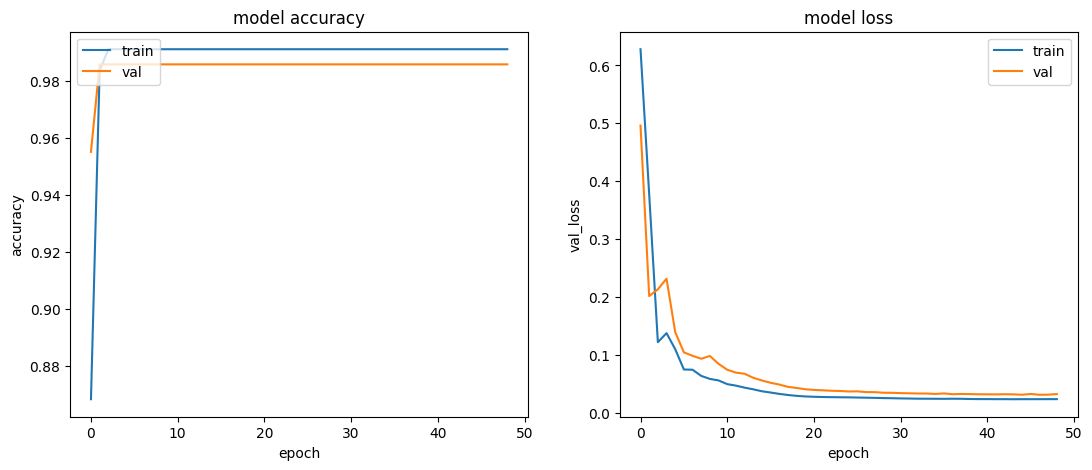

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

### Evaluate Model

Load in saved model

In [15]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/UNet/saved models/model1.h5')

Load in test images, their corresponding masks, and ground truth CSV files

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import ndimage
from PIL import Image

# Paths to image and mask folders, and the ground truth file
images_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/Test_clahe/images'
masks_folder = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/Test_clahe/masks'
ground_truth_file = '/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/ground_truth.csv'

# Get a list of filenames for images
image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]

# Initialize lists to store image and mask data
image_data = []
mask_data = []

# Initialize lists to store image names
image_names = []

# Load the ground truth from the single file
ground_truth_df = pd.read_csv(ground_truth_file)

for img_filename in image_files:
    # File paths for image and mask
    img_path = os.path.join(images_folder, img_filename)
    mask_path = os.path.join(masks_folder, img_filename)

    # Load image using OpenCV
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        image_data.append(image)
    else:
        print(f"Failed to load image: {img_path}")

    # Load mask using OpenCV
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        mask_data.append(mask)
    else:
        print(f"Failed to load mask: {mask_path}")

    if image is not None and mask is not None:
        img_name = os.path.splitext(img_filename)[0]  # Extract image name without extension
        image_names.append(img_name)  # Append image name to list

# # Convert lists to numpy arrays and ensure they have the same dimensions
# image_data = np.expand_dims(np.array(image_data), -1) / 255.0
# mask_data = np.expand_dims(np.array(mask_data), -1) / 255.0

# Convert lists to numpy arrays
image_data = np.expand_dims(np.array(image_data), 3) / 255
mask_data = np.expand_dims(np.array(mask_data), 3) / 255


Run Evaluation

In [20]:
def previewResults():
    testCases = image_data  # Use the loaded images
    testGroundTruth = mask_data  # Use the loaded masks
    imageNames = image_names

    # Run predictions (replace with actual prediction code)
    predictions = loaded_model.predict(testCases)  # Uncomment and use actual prediction code

    results_table = []
    within_5 = 0  # Counter for images within +/-5% AAE
    within_10 = 0  # Counter for images within +/-10% AAE
    greater_than_10 = 0  # Counter for images greater than +/-10% AAE

    for idx, (img, pred_mask, actual, names) in enumerate(zip(testCases, predictions, testGroundTruth, imageNames)):
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))

        ax[0].imshow(img.squeeze(), cmap='gray')
        ax[0].set_title(f"Image Name:\n {names}")
        ax[0].axis('off')


        img_mask = np.squeeze(pred_mask)
        plt.imsave('test.png', img_mask)

        image = Image.open('test.png').convert("L")
        img = np.asarray(image)
        img = img.copy()
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        t = 55
        (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

        # Convert grayscale image to color image
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Find contours depending on OpenCV version
        if cv2.__version__.startswith('3.'):
            (_, contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        elif cv2.__version__.startswith('4.'):
            (contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        else:
            raise ValueError("Unsupported OpenCV version")

        # Get the ground truth for the current image
        ground_truth_row = ground_truth_df[ground_truth_df['image name'] == f'{names}.png']
        if not ground_truth_row.empty:
            gt_count = int(ground_truth_row['ground truth'].values[0])
        else:
            gt_count = 0


        ax[1].imshow(actual.squeeze(), cmap='gray')
        ax[1].set_title(f"Ground Truth\nCells Count: {gt_count}")
        ax[1].axis('off')


        # Draw each contour with a different color
        for i, c in enumerate(contours):
            # Generate a random color for each contour
            color = np.random.randint(0, 256, 3)  # Random RGB color
            # Draw contour filled with the generated color
            cv2.drawContours(img_color, [c], -1, color.tolist(), thickness=cv2.FILLED)

        ax[2].imshow(img_color, cmap='gray')  # Show labeled components
        ax[2].set_title(f"Predicted\nCells Count: {len(contours)}")
        ax[2].axis('off')

         # Calculate AAE difference
        num_cells_pred = len(contours)
        raw_absolute_error = num_cells_pred - gt_count
        difference = abs(raw_absolute_error)

        results_table.append({
            'Image Name': names,
            'Ground Truth': gt_count,
            'Prediction': num_cells_pred,
            'Raw Absolute Error': raw_absolute_error,
            'AAE <=10': 'Yes' if abs(raw_absolute_error) <= 10 else 'No'
        })

        # Check if within +/-5 difference
        if abs(difference) <= 5:
            within_5 += 1

        # Check if within +/-10 difference
        if (abs(difference) > 5 and abs(difference) <= 10):
            within_10 += 1

        # Check if within +/-20 difference
        if abs(difference) > 10:
            greater_than_10 += 1

        plt.tight_layout()
        plt.show()

    # Display the results table
    results_df = pd.DataFrame(results_table)
    print(results_df)

    total_images = len(testCases)
    percent_within_5 = (within_5 / total_images) * 100
    percent_within_10 = (within_10 / total_images) * 100
    percent_greater_than_10 = (greater_than_10 / total_images) * 100

    # Save the results table to an Excel file
    summary_excel_path = '/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/UNet/UNet_prediction_summary_IDCIA.xlsx'
    results_df.to_excel(summary_excel_path, index=False)

previewResults()

Output hidden; open in https://colab.research.google.com to view.

In [21]:
def previewResults():
    testCases = image_data  # Use the loaded images
    testGroundTruth = mask_data  # Use the loaded masks
    imageNames = image_names

    # Run predictions (replace with actual prediction code)
    predictions = loaded_model.predict(testCases)  # Uncomment and use actual prediction code

    results_table = []
    within_5 = 0  # Counter for images within +/-5% AAE
    within_10 = 0  # Counter for images within +/-10% AAE
    greater_than_10 = 0  # Counter for images greater than +/-10% AAE


        # Create a directory to save the plots as images
    output_folder_plots = '/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/UNet/Test Results/test_segmentation output'
    os.makedirs(output_folder_plots, exist_ok=True)


    for idx, (img, pred_mask, actual, names) in enumerate(zip(testCases, predictions, testGroundTruth, imageNames)):
        fig, ax = plt.subplots(1, 3, figsize=(10, 3))

        ax[0].imshow(img.squeeze(), cmap='gray')
        ax[0].set_title(f"Image Name:\n {names}")
        ax[0].axis('off')


        img_mask = np.squeeze(pred_mask)
        plt.imsave('test.png', img_mask)

        image = Image.open('test.png').convert("L")
        img = np.asarray(image)
        img = img.copy()
        blur = cv2.GaussianBlur(img, (5, 5), 0)
        t = 55
        (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

        # Convert grayscale image to color image
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Find contours depending on OpenCV version
        if cv2.__version__.startswith('3.'):
            (_, contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        elif cv2.__version__.startswith('4.'):
            (contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        else:
            raise ValueError("Unsupported OpenCV version")

        # Get the ground truth for the current image
        ground_truth_row = ground_truth_df[ground_truth_df['image name'] == f'{names}.png']
        if not ground_truth_row.empty:
            gt_count = int(ground_truth_row['ground truth'].values[0])
        else:
            gt_count = 0


        ax[1].imshow(actual.squeeze(), cmap='gray')
        ax[1].set_title(f"Ground Truth\nCells Count: {gt_count}")
        ax[1].axis('off')


        # Draw each contour with a different color
        for i, c in enumerate(contours):
            # Generate a random color for each contour
            color = np.random.randint(0, 256, 3)  # Random RGB color
            # Draw contour filled with the generated color
            cv2.drawContours(img_color, [c], -1, color.tolist(), thickness=cv2.FILLED)

        ax[2].imshow(img_color, cmap='gray')  # Show labeled components
        ax[2].set_title(f"Predicted\nCells Count: {len(contours)}")
        ax[2].axis('off')

         # Calculate AAE difference
        num_cells_pred = len(contours)
        raw_absolute_error = num_cells_pred - gt_count
        difference = abs(raw_absolute_error)

        results_table.append({
            'Image Name': names,
            'Ground Truth': gt_count,
            'Prediction': num_cells_pred,
            'Raw Absolute Error': raw_absolute_error,
            'AAE <=10': 'Yes' if abs(raw_absolute_error) <= 10 else 'No'
        })

        # Check if within +/-5 difference
        if abs(difference) <= 5:
            within_5 += 1

        # Check if within +/-10 difference
        if (abs(difference) > 5 and abs(difference) <= 10):
            within_10 += 1

        # Check if within +/-20 difference
        if abs(difference) > 10:
            greater_than_10 += 1

        plt.tight_layout()
        # Save the plot as an image
        output_filename_plot = os.path.join(output_folder_plots, f'{names}.png')
        plt.savefig(output_filename_plot, bbox_inches='tight')
        plt.close()


    # Display the results table
    results_df = pd.DataFrame(results_table)
    print(results_df)

    total_images = len(testCases)
    percent_within_5 = (within_5 / total_images) * 100
    percent_within_10 = (within_10 / total_images) * 100
    percent_greater_than_10 = (greater_than_10 / total_images) * 100

    # Save the results table to an Excel file
    summary_excel_path = '/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/UNet/UNet_prediction_summary_IDCIA.xlsx'
    results_df.to_excel(summary_excel_path, index=False)

previewResults()

4/4 [==============================] - 1s 195ms/step
                                 Image Name  Ground Truth  Prediction  \
0   220909_GFP-AHPC_D_MAP2ab_F1_Cy3_ND2_20x           112         155   
1   220909_GFP-AHPC_D_MAP2ab_F2_Cy3_ND2_20x            73         168   
2   220909_GFP-AHPC_D_MAP2ab_F4_Cy3_ND2_20x           127         149   
3   220909_GFP-AHPC_D_MAP2ab_F5_Cy3_ND2_20x            94         149   
4   220909_GFP-AHPC_D_MAP2ab_F7_Cy3_ND2_20x            57          96   
..                                      ...           ...         ...   
95   220909_GFP-AHPC_B_GFAP_F10_Cy3_ND2_20x             0          46   
96    220909_GFP-AHPC_B_GFAP_F2_Cy3_ND2_20x             2         215   
97    220909_GFP-AHPC_B_GFAP_F3_Cy3_ND2_20x             0         100   
98    220909_GFP-AHPC_B_GFAP_F4_Cy3_ND2_20x             0          83   
99    220909_GFP-AHPC_B_GFAP_F6_Cy3_ND2_20x             1          88   

    Raw Absolute Error AAE <=10  
0                   43       No  
1 